In [1]:
library(tidyverse)
options(repr.plot.height=4, repr.plot.width=6)
theme_set(theme_classic())

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.0     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()


# Lecture 20: Classification and logistic regression

In this lecture we'll study techniques for modeling categorical outcomes, as well as methods of discovering new categories.

## Deaths on the *RMS Titanic*
The RMS Titanic famously sank on April 15, 1912 during its maiden voyage, killing about 2/3rds of its passengers. The `titanic` data set records the fates of everyone aboard.

In [160]:
data(Titanic)
titanic_df <- Titanic %>% as_tibble %>% 
    mutate(Survived = Survived == "Yes") %>% print

# A tibble: 32 x 5
   Class Sex    Age   Survived     n
   <chr> <chr>  <chr> <lgl>    <dbl>
 1 1st   Male   Child FALSE        0
 2 2nd   Male   Child FALSE        0
 3 3rd   Male   Child FALSE       35
 4 Crew  Male   Child FALSE        0
 5 1st   Female Child FALSE        0
 6 2nd   Female Child FALSE        0
 7 3rd   Female Child FALSE       17
 8 Crew  Female Child FALSE        0
 9 1st   Male   Adult FALSE      118
10 2nd   Male   Adult FALSE      154
# … with 22 more rows


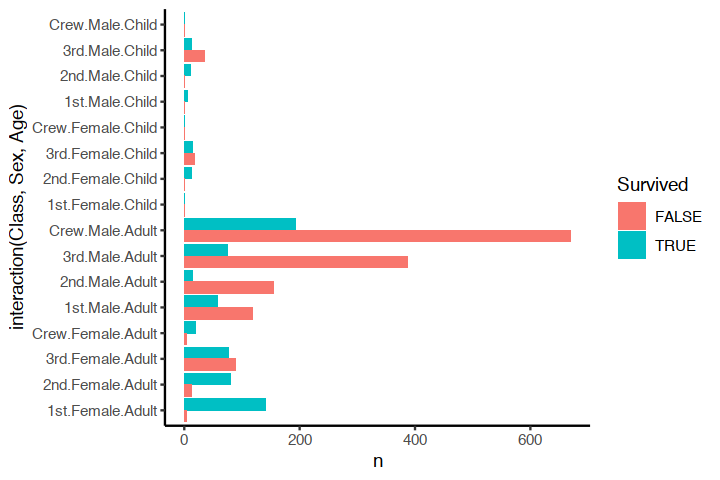

In [161]:
ggplot(titanic_df) + geom_col(aes(x=interaction(Class, Sex, Age), y=n, fill=Survived), 
                              position='dodge') + coord_flip()

We have three categorical predictors: sex, age (adult / child), and class (1st-3rd or crew). Our outcome is also categorical: survived or not.

## Contingency tables
The `Titanic` data actually come in the form of a *contingency table*:

In [157]:
Titanic %>% str

 'table' num [1:4, 1:2, 1:2, 1:2] 0 0 35 0 0 0 17 0 118 154 ...
 - attr(*, "dimnames")=List of 4
  ..$ Class   : chr [1:4] "1st" "2nd" "3rd" "Crew"
  ..$ Sex     : chr [1:2] "Male" "Female"
  ..$ Age     : chr [1:2] "Child" "Adult"
  ..$ Survived: chr [1:2] "No" "Yes"


This is the basic way we represent categorical data in statistics. This table has four dimensions:

In [5]:
dim(Titanic)

[1] 4 2 2 2

To find out what the dimensions represent, we use:

In [6]:
dimnames(Titanic)

$Class
[1] "1st"  "2nd"  "3rd"  "Crew"

$Sex
[1] "Male"   "Female"

$Age
[1] "Child" "Adult"

$Survived
[1] "No"  "Yes"


Often we will want to *marginalize* the table, meaning sum out one or more of its axes.

In [167]:
margin.table(Titanic, margin = c(1, 2))  # this restricts to the first dimension
margin.table(Titanic, margin = -c(3, 4))  # this sums over the third and fourth dimensions

      Sex
Class  Male Female
  1st   180    145
  2nd   179    106
  3rd   510    196
  Crew  862     23

      Sex
Class  Male Female
  1st   180    145
  2nd   179    106
  3rd   510    196
  Crew  862     23

Let's consider the basic question: was survival independent of whether you were a child or an adult?

In [171]:
margin.table(Titanic, margin=-c(1, 2)) %>% print %>% chisq.test

       Survived
Age       No  Yes
  Child   52   57
  Adult 1438  654



	Pearson's Chi-squared test with Yates' continuity correction

data:  .
X-squared = 20.005, df = 1, p-value = 7.725e-06


We might also want to calculate proportions:

In [195]:
# margin.table(Titanic, margin=-c(2)) # %>% prop.table
margin.table(Titanic, margin=-1) %>% prop.table(margin=3) %>% print
# margin.table(Titanic, margin=-c(1, 2)) %>% prop.table(margin=2)

, , Survived = No

        Age
Sex           Child      Adult
  Male   0.02348993 0.89194631
  Female 0.01140940 0.07315436

, , Survived = Yes

        Age
Sex           Child      Adult
  Male   0.04078762 0.47538678
  Female 0.03938115 0.44444444



Finally, we could test for differences in proportions:

In [196]:
margin.table(Titanic, margin=c(1, 4)) %>% print %>% prop.test

      Survived
Class   No Yes
  1st  122 203
  2nd  167 118
  3rd  528 178
  Crew 673 212



	4-sample test for equality of proportions without continuity
	correction

data:  .
X-squared = 190.4, df = 3, p-value < 2.2e-16
alternative hypothesis: two.sided
sample estimates:
   prop 1    prop 2    prop 3    prop 4 
0.3753846 0.5859649 0.7478754 0.7604520 


#### Exercise
Recall the `UCBAdmissions` data. (Easily) test for differences in the proportion of male and female admits, with and without stratifying by department.

In [226]:
# dimnames(UCBAdmissions)
UCBAdmissions %>% prop.table(margin = c(2, 3))
# prop.table(margin = 1)

# prop.test
# prop.test(x = , n = )

, , Dept = A

          Gender
Admit            Male     Female
  Admitted 0.62060606 0.82407407
  Rejected 0.37939394 0.17592593

, , Dept = B

          Gender
Admit            Male     Female
  Admitted 0.63035714 0.68000000
  Rejected 0.36964286 0.32000000

, , Dept = C

          Gender
Admit            Male     Female
  Admitted 0.36923077 0.34064081
  Rejected 0.63076923 0.65935919

, , Dept = D

          Gender
Admit            Male     Female
  Admitted 0.33093525 0.34933333
  Rejected 0.66906475 0.65066667

, , Dept = E

          Gender
Admit            Male     Female
  Admitted 0.27748691 0.23918575
  Rejected 0.72251309 0.76081425

, , Dept = F

          Gender
Admit            Male     Female
  Admitted 0.05898123 0.07038123
  Rejected 0.94101877 0.92961877


## Building contigency tables
To convert a data frame to contingency table format, use `xtabs()`. 

For example: is flight delay independent of departure airport?

In [232]:
library(nycflights13)
tbl <- xtabs(~ origin + (dep_delay > 0), data=flights) %>% print
chisq.test(tbl)
prop.test(tbl)

      dep_delay > 0
origin FALSE  TRUE
   EWR 64885 52711
   JFK 67385 42031
   LGA 67819 33690



	Pearson's Chi-squared test

data:  tbl
X-squared = 3129.1, df = 2, p-value < 2.2e-16



	3-sample test for equality of proportions without continuity
	correction

data:  tbl
X-squared = 3129.1, df = 2, p-value < 2.2e-16
alternative hypothesis: two.sided
sample estimates:
   prop 1    prop 2    prop 3 
0.5517620 0.6158606 0.6681082 


## Logistic regression
Suppose we want to build a regression model for predicting categorical outcomes.
In all of the regressions we have seen so far, the dependent ($y$) variable has been continuous: life expectancy, price, etc. However, there are many situations where the outcome is categorical. For simplicity, we will assume it's binary, and can be coded as 0/1. How should we model binary data?

One idea is to just stick what we know and use the linear model. Will this work?

In [234]:
mdl <- lm(Survived ~ Class + Sex + Age, weights = n, data = titanic_df)
summary(mdl)


Call:
lm(formula = Survived ~ Class + Sex + Age, data = titanic_df, 
    weights = n)

Weighted Residuals:
   Min     1Q Median     3Q    Max 
-5.870 -1.675  0.000  1.449 10.714 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)   0.8930     0.2855   3.128  0.00581 **
Class2nd     -0.1861     0.3645  -0.510  0.61592   
Class3rd     -0.3067     0.3060  -1.002  0.32939   
ClassCrew    -0.1756     0.3088  -0.568  0.57677   
SexMale      -0.4907     0.2540  -1.931  0.06932 . 
AgeChild      0.1813     0.4524   0.401  0.69333   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.469 on 18 degrees of freedom
Multiple R-squared:  0.2529,	Adjusted R-squared:  0.04543 
F-statistic: 1.219 on 5 and 18 DF,  p-value: 0.3404


It seems okay. R did not generate any errors. But what does this regression actually mean? Remember from 250 our basic assumption: the residuals of our regression should be normally distributed. Does this hold up?

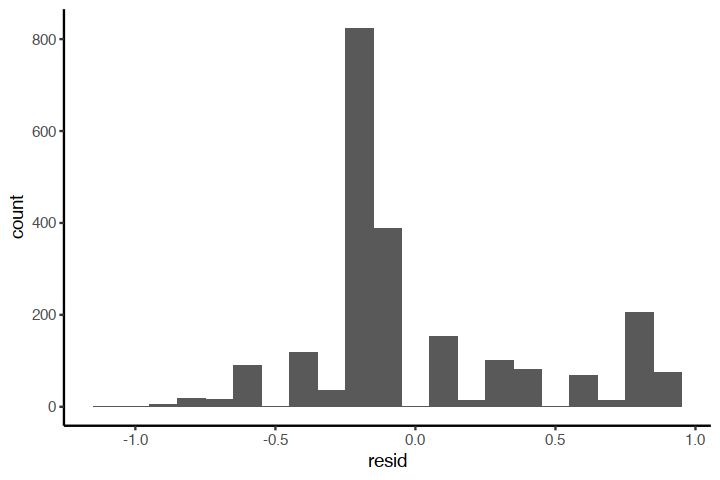

In [236]:
library(modelr)
titanic_df %>% add_residuals(mdl) %>% mutate(resid=as.numeric(resid)) %>% 
    ggplot + geom_histogram(aes(x=resid, weight = n), binwidth=.1)

What about predictions?

In [16]:
titanic_df %>% add_predictions(mdl) %>% filter(pred > 1)

  Class Sex    Age   Survived n pred    
1 1st   Female Child FALSE    0 1.074325
2 1st   Female Child  TRUE    1 1.074325

The linear model is fundamentally wrong for categorical outcomes, because the normal distribution is not discrete. (Note that categorical covariates are fine.) 

The linear model says:

$$y = f(a + b x)$$ 

for $f(x)=x$. For 0/1 outcomes, let's instead try to think probabilistically:

$$\text{Prob}(y=1) = \underbrace{f(a + b x)}_{(\text{some function of the covariates})}$$

What criteria should this function $f$ have?
- It's range needs to be $[0,1]$.
- For "extreme" values of $a + bx$ it should tend to zero one one.

A function which satisfies both the properties is the **logistic function**:
$$f(x) = \frac{1}{1 + e^{-x}}.$$

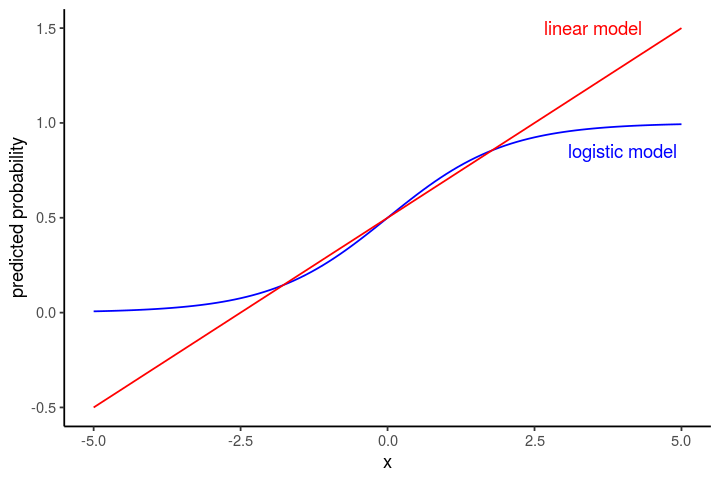

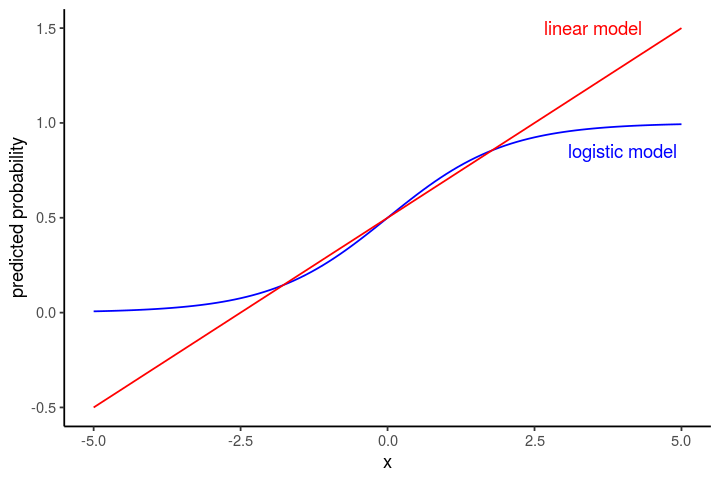

In [107]:
expand.grid(x=seq(-5, 5, .1)) %>% ggplot(aes(x=x)) + 
    stat_function(fun=function(x) (1 / (1 + exp(-x))), xlim=c(-5, 5), color="blue") +
    stat_function(fun=function(x) 1/2 + x/5, xlim=c(-5, 5), color="red") +
    annotate(x=3.5, y=1.5, geom="text", label="linear model", color="red") +
    annotate(x=4.0, y=.85, geom="text", label="logistic model", color="blue") + 
    ylab("predicted probability")

Let's re-do our model fitting and residual diagnostics using this model:

In [244]:
mdl <- glm(Survived ~ Class + Age + Sex, 
           data = titanic_df, 
           weights = n, 
           family = "binomial")
summary(mdl)


Call:
glm(formula = Survived ~ Class + Age + Sex, family = "binomial", 
    data = titanic_df, weights = n)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-18.505   -4.247    0.000    4.747   23.915  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   2.0438     0.1679  12.171  < 2e-16 ***
Class2nd     -1.0181     0.1960  -5.194 2.05e-07 ***
Class3rd     -1.7778     0.1716 -10.362  < 2e-16 ***
ClassCrew    -0.8577     0.1573  -5.451 5.00e-08 ***
AgeChild      1.0615     0.2440   4.350 1.36e-05 ***
SexMale      -2.4201     0.1404 -17.236  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2769.5  on 23  degrees of freedom
Residual deviance: 2210.1  on 18  degrees of freedom
AIC: 2222.1

Number of Fisher Scoring iterations: 5


These results look very different from linear regression. The way we interpret the coefficients in the logistic regression is different than in ordinary regression. They are interpreted in terms of the *log-odds ratio*. The model we estimated above is 

$$\underbrace{ \log\left( \frac{p_\text{survival}}{1-p_\text{survival}}  \right)}_\text{log odds ratio} = 2.04-1.02\times\texttt{\{2nd class\}}+\cdots-2.42\times \texttt{male}$$

Let's again look at the predictions generated by our model. The predictions are now interpreted as the probability of surviving:

In [245]:
titanic_df %>% add_predictions(mdl) %>%     
    arrange(pred) %>% print

# A tibble: 32 x 6
   Class Sex   Age   Survived     n   pred
   <chr> <chr> <chr> <lgl>    <dbl>  <dbl>
 1 3rd   Male  Adult FALSE      387 -2.15 
 2 3rd   Male  Adult TRUE        75 -2.15 
 3 2nd   Male  Adult FALSE      154 -1.39 
 4 2nd   Male  Adult TRUE        14 -1.39 
 5 Crew  Male  Adult FALSE      670 -1.23 
 6 Crew  Male  Adult TRUE       192 -1.23 
 7 3rd   Male  Child FALSE       35 -1.09 
 8 3rd   Male  Child TRUE        13 -1.09 
 9 1st   Male  Adult FALSE      118 -0.376
10 1st   Male  Adult TRUE        57 -0.376
# … with 22 more rows


#### Exercise
What effects do air time, day of the week, and plane size (# of passengers) have on the probability that a flight is delayed?

In [258]:
library(nycflights13)
# flights %>% mut
left_join(flights, planes, by = "tailnum") %>% mutate(day_of_week = as.character(lubridate::wday(time_hour, label = T))) %>% 
    glm(dep_delay > 0 ~ air_time +  day_of_week + seats, data = .) %>% summary



Call:
glm(formula = dep_delay > 0 ~ air_time + day_of_week + seats, 
    data = .)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5355  -0.4074  -0.3628   0.5808   0.7177  

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     4.294e-01  3.053e-03 140.629  < 2e-16 ***
air_time        2.581e-04  1.118e-05  23.087  < 2e-16 ***
day_of_weekMon -2.464e-02  3.389e-03  -7.269 3.62e-13 ***
day_of_weekSat -7.774e-02  3.633e-03 -21.396  < 2e-16 ***
day_of_weekSun -3.843e-02  3.458e-03 -11.114  < 2e-16 ***
day_of_weekThu  5.337e-03  3.402e-03   1.569    0.117    
day_of_weekTue -6.296e-02  3.391e-03 -18.565  < 2e-16 ***
day_of_weekWed -5.494e-02  3.399e-03 -16.165  < 2e-16 ***
seats          -2.328e-04  1.514e-05 -15.375  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.2391455)

    Null deviance: 67085  on 279016  degrees of freedom
Residual deviance

## Clustering and PCA
Sometimes our data have categories, they are just not easy to see. Consider the follow data set:

In [30]:
load('nci60.RData')
str(NCI60)

List of 2
 $ data: num [1:64, 1:6830] 0.3 0.68 0.94 0.28 0.485 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:64] "V1" "V2" "V3" "V4" ...
  .. ..$ : chr [1:6830] "1" "2" "3" "4" ...
 $ labs: chr [1:64] "CNS" "CNS" "CNS" "RENAL" ...


This is NCI microarray data ([source](https://cran.r-project.org/web/packages/ISLR/index.html)). The data contains expression levels on 6830 genes from 64 cancer cell lines. Cancer type is also recorded.

In [149]:
nci60_df <- as.data.frame(NCI60$data) %>% tbl_df %>% mutate(label = NCI60$labs) %>% print

# A tibble: 64 x 6,831
      `1`    `2`    `3`    `4`    `5`       `6`    `7`    `8`     `9`    `10`
    <dbl>  <dbl>  <dbl>  <dbl>  <dbl>     <dbl>  <dbl>  <dbl>   <dbl>   <dbl>
 1  0.3    1.18   0.55   1.14  -0.265 -7.00e- 2  0.35  -0.315 -0.45   -0.655 
 2  0.680  1.29   0.170  0.380  0.465  5.80e- 1  0.700  0.725 -0.0400 -0.285 
 3  0.94  -0.04  -0.17  -0.04  -0.605  0.        0.09   0.645  0.43    0.475 
 4  0.28  -0.31   0.68  -0.81   0.625 -1.39e-17  0.17   0.245  0.02    0.0950
 5  0.485 -0.465  0.395  0.905  0.2   -5.00e- 3  0.085  0.11   0.235   1.49  
 6  0.31  -0.03  -0.1   -0.46  -0.205 -5.40e- 1 -0.64  -0.585 -0.77   -0.245 
 7 -0.83   0      0.13  -1.63   0.075 -3.60e- 1  0.1    0.155 -0.290  -0.0850
 8 -0.19  -0.87  -0.45   0.08   0.005  3.50e- 1 -0.04  -0.265 -0.31   -0.245 
 9  0.46   0      1.15  -1.4   -0.005 -7.00e- 1 -0.92  -0.515 -0.28   -0.115 
10  0.76   1.49   0.28   0.1   -0.525  3.60e- 1  0.6    0.175  0.580   1.15  
# … with 54 more rows, and 6,821 more var

There are 64 observations and each one has close to 7,000 covariates. We will never get anywhere exploring the data by hand.

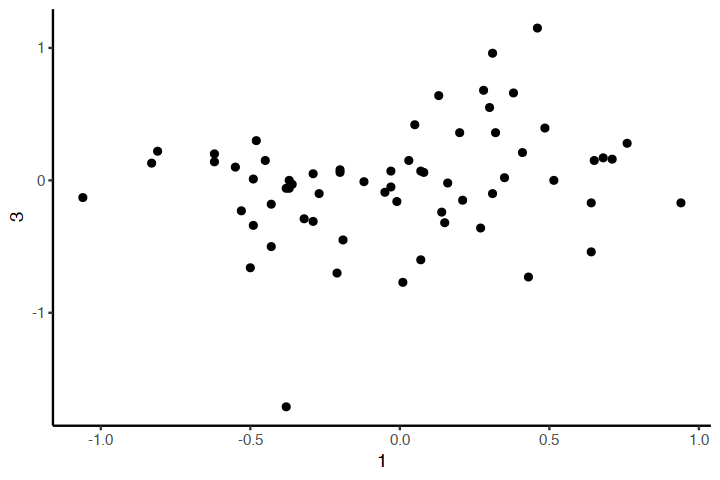

In [81]:
ggplot(nci60_df) + geom_point(aes(x=`1`, y=`3`))

Our first strategy will be to "reduce" the dimensionality of these data. To do this we'll use [principal components analysis](https://en.wikipedia.org/wiki/Principal_component_analysis).

In [82]:
pca <- nci60_df %>% select(-label) %>% prcomp(center = T, scale = T)

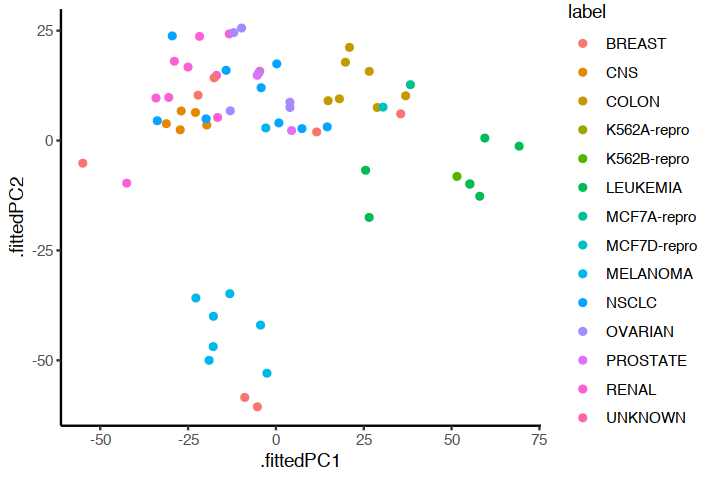

In [83]:
nci60_pca <- broom::augment(pca, data = nci60_df)
ggplot(nci60_pca, aes(x=.fittedPC1, y=.fittedPC2, color=label)) + geom_point() 

We can combine PCA with clustering. To discover some categories in the data, we start by using [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering).

In [85]:
clust <- kmeans(select(nci60_df, -label), centers = 3, nstart = 25)

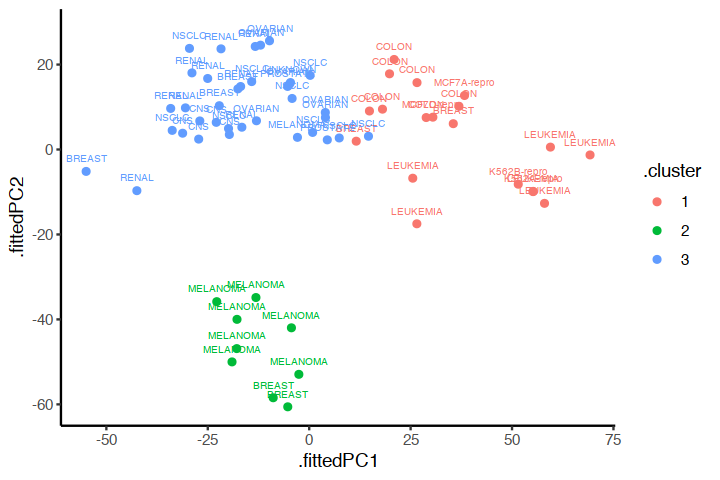

In [130]:
broom::augment(clust, data = nci60_pca) %>% 
    ggplot(aes(x=.fittedPC1, y=.fittedPC2, color=.cluster)) + 
    geom_point() + geom_text(aes(label=label), size = 2, nudge_y = 3)

Another type of clustering organizes the data into a hierarchy. 

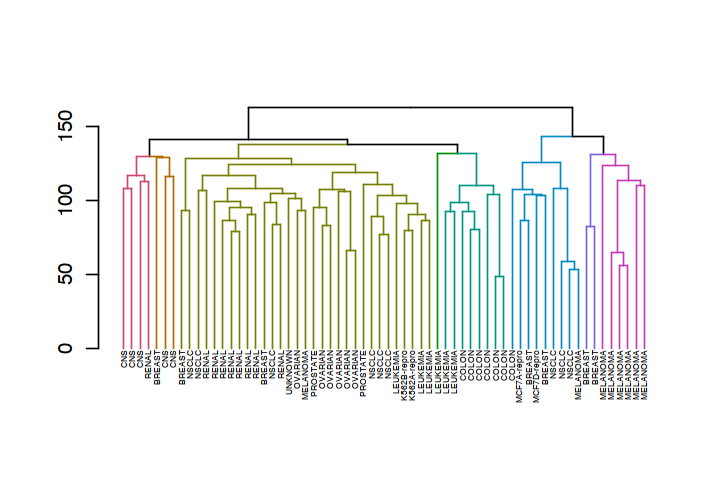

In [124]:
library(dendextend)
NCI60$data %>% scale %>% dist %>% hclust(method = "complete") %>% 
    as.dendrogram %>% set("labels", NCI60$labs) %>% 
    set("branches_k_color", k = 8) %>% set("labels_cex", .4) %>% plot

Something interesting happens when we cluster using the first PCs, instead of the original data:

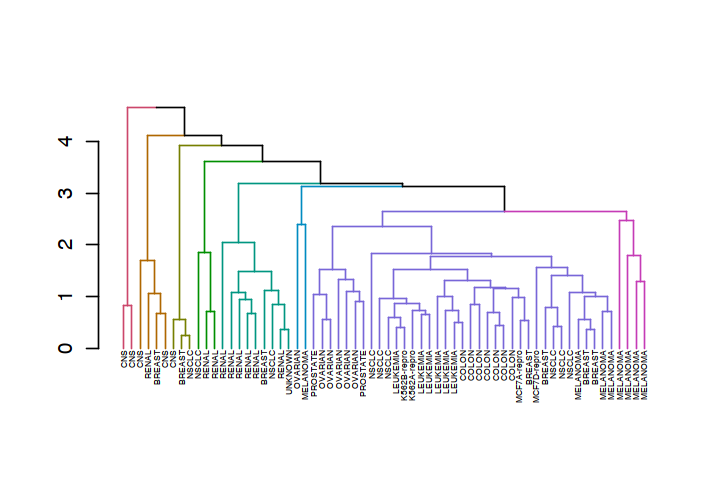

In [135]:
select(nci60_pca, .fittedPC1:.fittedPC5) %>% scale %>% dist %>% hclust(method = "average") %>% 
    as.dendrogram %>% set("labels", NCI60$labs) %>% 
    set("branches_k_color", k = 8) %>% set("labels_cex", .4) %>% plot

## Functions

Often when programming we find ourselves repeating the same block of code with minor modifications. Suppose we want to normalize each column of this tibble to be in $[0,1]$:

In [266]:
df = tibble::tibble(
  a = rnorm(10),
  b = rnorm(10),
  c = rnorm(10),
  d = rnorm(10)
) %>% print

# A tibble: 10 x 4
         a       b       c       d
     <dbl>   <dbl>   <dbl>   <dbl>
 1 -0.206  -0.737   0.0176  0.817 
 2 -0.574  -0.201  -0.390  -0.0606
 3 -1.39    1.10   -0.491  -0.501 
 4 -0.0704 -0.0167 -1.05    0.926 
 5 -0.431   0.162  -0.896   0.0369
 6 -0.592   2.02    1.27   -1.07  
 7  0.981  -0.704   0.594  -0.238 
 8  0.532   0.961   0.776   1.50  
 9 -0.0905  1.79    1.56    1.17  
10  0.156  -1.06   -0.365  -1.46  


To normalize we'll subtract the min from each column and divide by its range:

In [264]:
df$a <- (df$a - min(df$a, na.rm = TRUE)) / 
  (max(df$a, na.rm = TRUE) - min(df$a, na.rm = TRUE))
df$b <- (df$b - min(df$b, na.rm = TRUE)) / 
  (max(df$b, na.rm = TRUE) - min(df$b, na.rm = TRUE))
df$c <- (df$c - min(df$c, na.rm = TRUE)) / 
  (max(df$c, na.rm = TRUE) - min(df$c, na.rm = TRUE))
df$d <- (df$d - min(df$d, na.rm = TRUE)) / 
  (max(df$d, na.rm = TRUE) - min(df$d, na.rm = TRUE))

print(df)

ERROR: Error in df$a: object of type 'closure' is not subsettable


This required a bunch of repetitive typing. (Worse, there is an error in the code.) In situations like this we should write a function!

## Anatomy of a function
To write a function we should first think about the inputs and output. A function takes input(s), does something(s) to them, and then returns an output.

What are the input(s) and output of our normalize function?
```{r}
df$a <- (df$a - min(df$a, na.rm = TRUE)) / 
  (max(df$a, na.rm = TRUE) - min(df$a, na.rm = TRUE))
```

We will call our function `rescale01`. The input is the vector we wish to normalize, and the output is the a copy of the vector where each entry is normalized.

In [260]:
rescale01 <- function(x) {
#  ^ function name   ^ function argument (input vector)
    (x - min(x, na.rm = TRUE)) / (max(x, na.rm = TRUE) - min(x, na.rm = TRUE))
#   ^ function output
}

Notice how we have taken our code and converted every instance of `df$a` to `x`, which is the name that we have assigned to our function argument.

Let's test our function on a few examples:

In [262]:
rescale01(c(.01, .2, .3))

[1] 0.0000000 0.6551724 1.0000000

In [263]:
rescale01(c(1,0,3,2))

[1] 0.3333333 0.0000000 1.0000000 0.6666667

Now that we have defined our function, we can replace our code with a nicer looking version:

In [267]:
df$a = rescale01(df$a)
df$b = rescale01(df$b)
df$c = rescale01(df$c)
df$d = rescale01(df$d)

This is considerably simpler, but still has some repetition. Soon we will learn about iteration and ways to cut down further on repetition.

## Conditional execution
Often when writing functions we need to do different things depending on what data is passed in. This is known as *conditional execution*, and is accomplished using the `if/else` construct:
```{r}
if (condition) {
  # code executed when condition is TRUE
} else {
  # code executed when condition is FALSE
}
```

### Exercise
Write a function `fizzbuzz(x)` that prints "fizz" if x is less than three, and "buzz" otherwise.
```{r}
> fizzbuzz(3)
[1] "fizz"
> fizzbuzz(4)
[2] "buzz"
```

In [268]:
# Solution
fizzbuzz <- function(x) {
    if (x < 3) {
        print("fizz")
    } else {
        print("buzz")
    }
}

fizzbuzz(1)

[1] "fizz"


`if/else` and `ifelse()` are very different. `ifelse()` is a *function* that takes three vector arguments and returns a new vector. `if/else` tells R to conditionally execute code.

### Conditions
The `condition` part of the `if` statement must evaluate to either a single `TRUE` or `FALSE`. If it does not, you will get a warning:

In [104]:
if (c(T, F)) { 1 } else { }

ifelse(
    1:10 > 5,
    "gt5",
    "lte5"
)] 

Warning message in if (c(T, F)) {:
“the condition has length > 1 and only the first element will be used”

[1] 1

 [1] FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE

(Why?) Similarly, a condition of `NA` will generate an error:
```{r}
> if (NA) { 1 }
Error in if (NA) {: missing value where TRUE/FALSE needed
Traceback:
```

#### Logical operators
Often you will need to combine multiple logical conditions in an `if` statement. To do this we have the `&&` and `||` operators, which take the logical `and` and `or`, respectively, of several logical conditions:

In [271]:
# today's weather
rain <- TRUE
temp <- 41
can_wear_shorts <- (rain == FALSE) && (temp > 62)
print(can_wear_shorts)

[1] FALSE


There is a subtle but important difference betwen the single and double versions of these operators. The single `&` performs entrywise `AND` over logical vectors:

In [275]:
# today's weather and last thursday's weather
rain <- c(TRUE, FALSE)
temp <- c(41, 65)
# can_wear_shorts1 <- (rain == FALSE) & (temp > 60)
can_wear_shorts2 <- (rain == FALSE) && (temp > 60)
# print(can_wear_shorts1)
print(can_wear_shorts2)
 
if (c(T, F)) {
    print("TF")
}

[1] FALSE


Warning message in if (c(T, F)) {:
“the condition has length > 1 and only the first element will be used”

[1] "TF"


#### Testing for equality
Be careful when testing for equality in conditionals. The `==` operator will return a *vector* of logicals. If you want to make sure that any/all entries of a vector are `TRUE`, use the `any()` or `all()` functions:

In [112]:
v1 = c(1, 2, 3)
v2 = c(1, 1, 2)
v1 == v2
all(v1 == v2)
any(v1 == v2)
#if (v1 == v2) { print("Wrong!") }
#if (all(v1 == v2)) { print("All!") }
#if (any(v1 == v2)) { print("Any!") }

[1]  TRUE FALSE FALSE

[1] FALSE

[1] TRUE